In [5]:
import pandas as pd
import numpy as np
import jieba
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.utils import plot_model

In [6]:
# 加载训练集和测试集数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [7]:
def tokenize(text):
    return ' '.join(jieba.cut(text))

train_data['content'] = train_data['content'].apply(tokenize)
train_data['title'] = train_data['title'].apply(tokenize)
train_data['tag'] = train_data['tag'].apply(tokenize)
test_data['content'] = test_data['content'].apply(tokenize)
test_data['title'] = test_data['title'].apply(tokenize)
test_data['tag'] = test_data['tag'].apply(tokenize)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\13414\AppData\Local\Temp\jieba.cache
Loading model cost 0.520 seconds.
Prefix dict has been built successfully.


In [8]:
# 创建词汇表

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['content'].tolist() + train_data['title'].tolist() + train_data['tag'].tolist())

# 将文本转化为序列
train_content_seq = tokenizer.texts_to_sequences(train_data['content'].tolist())
train_title_seq = tokenizer.texts_to_sequences(train_data['title'].tolist())
train_tag_seq = tokenizer.texts_to_sequences(train_data['tag'].tolist())
test_content_seq = tokenizer.texts_to_sequences(test_data['content'].tolist())
test_title_seq = tokenizer.texts_to_sequences(test_data['title'].tolist())
test_tag_seq = tokenizer.texts_to_sequences(test_data['tag'].tolist())

In [9]:
# 对序列进行填充
maxlen = 500
train_content_seq = pad_sequences(train_content_seq, padding='post', maxlen=maxlen)
train_title_seq = pad_sequences(train_title_seq, padding='post', maxlen=maxlen)
train_tag_seq = pad_sequences(train_tag_seq, padding='post', maxlen=maxlen)
test_content_seq = pad_sequences(test_content_seq, padding='post', maxlen=maxlen)
test_title_seq = pad_sequences(test_title_seq, padding='post', maxlen=maxlen)
test_tag_seq = pad_sequences(test_tag_seq, padding='post', maxlen=maxlen)

In [10]:
# 构建模型
input_content = Input(shape=(maxlen,))
input_title = Input(shape=(maxlen,))
input_tag = Input(shape=(maxlen,))

embedding_dim = 200
num_filters = 128
filter_sizes = [3, 4, 5]

embedding_layer = Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=maxlen)

content_embedding = embedding_layer(input_content)
title_embedding = embedding_layer(input_title)
tag_embedding = embedding_layer(input_tag)

conv_blocks = []
for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(content_embedding)
    conv = MaxPooling1D(pool_size=maxlen - filter_size + 1)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(title_embedding)
    conv = MaxPooling1D(pool_size=maxlen - filter_size + 1)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(tag_embedding)
    conv = MaxPooling1D(pool_size=maxlen - filter_size + 1)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

merge = concatenate(conv_blocks, axis=-1)
dense = Dense(128, activation='relu')(merge)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[input_content, input_title, input_tag], outputs=output)

In [11]:
# 编译训练模型
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x=[train_content_seq, train_title_seq, train_tag_seq], y=train_data['label'].values, batch_size=64,
                    epochs=20, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/20
57/57 [==============================] - 37s 620ms/step - loss: 0.5884 - accuracy: 0.6770 - val_loss: 0.4794 - val_accuracy: 0.7350
Epoch 2/20
57/57 [==============================] - 36s 634ms/step - loss: 0.3060 - accuracy: 0.8746 - val_loss: 0.3242 - val_accuracy: 0.8600
Epoch 3/20
57/57 [==============================] - 34s 603ms/step - loss: 0.0685 - accuracy: 0.9803 - val_loss: 0.3731 - val_accuracy: 0.8500
Epoch 4/20
57/57 [==============================] - 36s 628ms/step - loss: 0.0116 - accuracy: 0.9989 - val_loss: 0.4201 - val_accuracy: 0.8575
Epoch 5/20
57/57 [==============================] - 36s 624ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.4498 - val_accuracy: 0.8475


In [19]:
y_pred = model.predict([test_content_seq, test_title_seq, test_tag_seq])
y_pred_round = np.round(y_pred).flatten()

32/32 [==============================] - 2s 62ms/step


In [21]:
# 将预测结果写入文件
test_data['pre_label_round'] = y_pred
test_data['pre_label'] = y_pred_round
test_data['confidence'] = confidence
test_data.to_csv('TextCNNRes.csv', index=False)

In [22]:
accuracy = accuracy_score(test_data['label'].values, y_pred)
precision, recall, f1_score, support = precision_recall_fscore_support(test_data['label'].values, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)
print('Support:', support)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# 计算混淆矩阵
conf_mat = confusion_matrix(test_data['label'], y_pred)

In [ ]:
# 可视化混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt

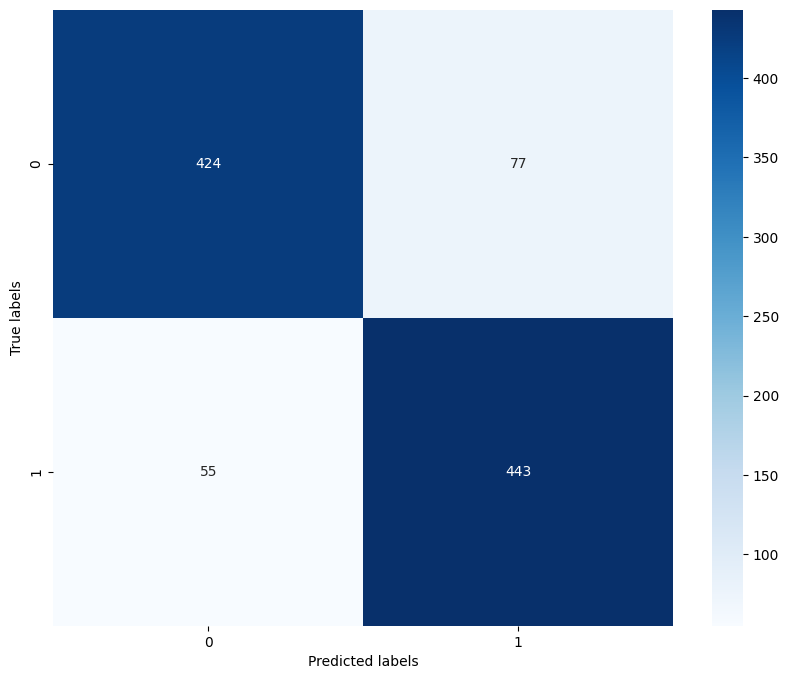

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()